# Import necessary libraries


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error


from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load the dataset


In [2]:
# Load the dataset
file_path = 'ETTh1_without_missing.csv'
df = pd.read_csv(file_path)
df.head()


,Id,date,OT,Unnamed: 3
0,0,2016-07-01 00:00:00,30.531000,NaN
1,1,2016-07-01 01:00:00,27.787001,NaN
2,2,2016-07-01 02:00:00,27.787001,NaN
3,3,2016-07-01 03:00:00,25.044001,NaN
4,4,2016-07-01 04:00:00,21.948000,NaN


# Drop unnecessary columns and convert 'date' to datetime format


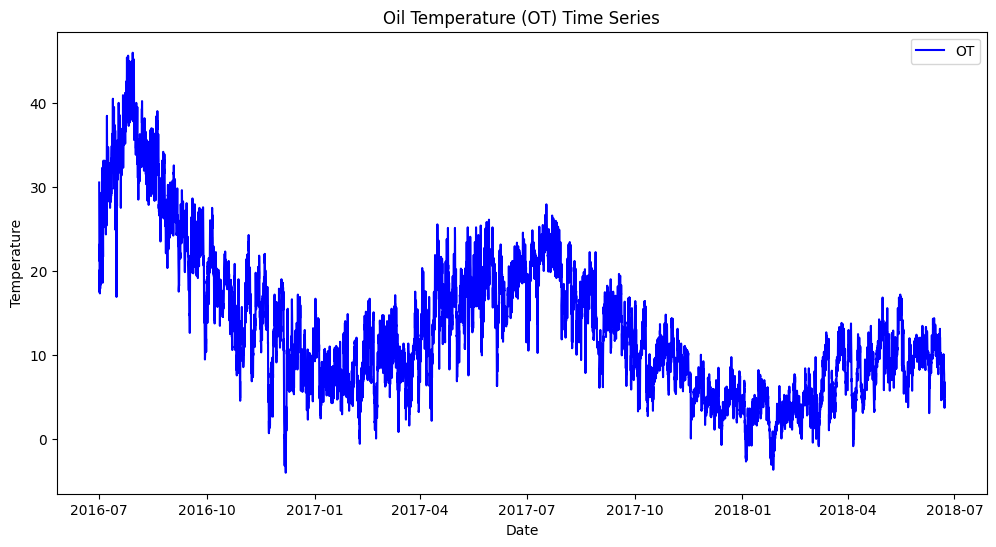

In [3]:
df.drop(['Id', 'Unnamed: 3'], axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date'])

# Set 'date' as the index of the dataframe
df.set_index('date', inplace=True)
# Visualize the 'OT' time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['OT'], label='OT', color='blue')
plt.title('Oil Temperature (OT) Time Series')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

#WE ARE PLOTTNG WITH A ROLLING TO SEE IF THERE'S A TREND AND DECIDED IF DATA'S SHOULD BE NORMALIZED OR NOT


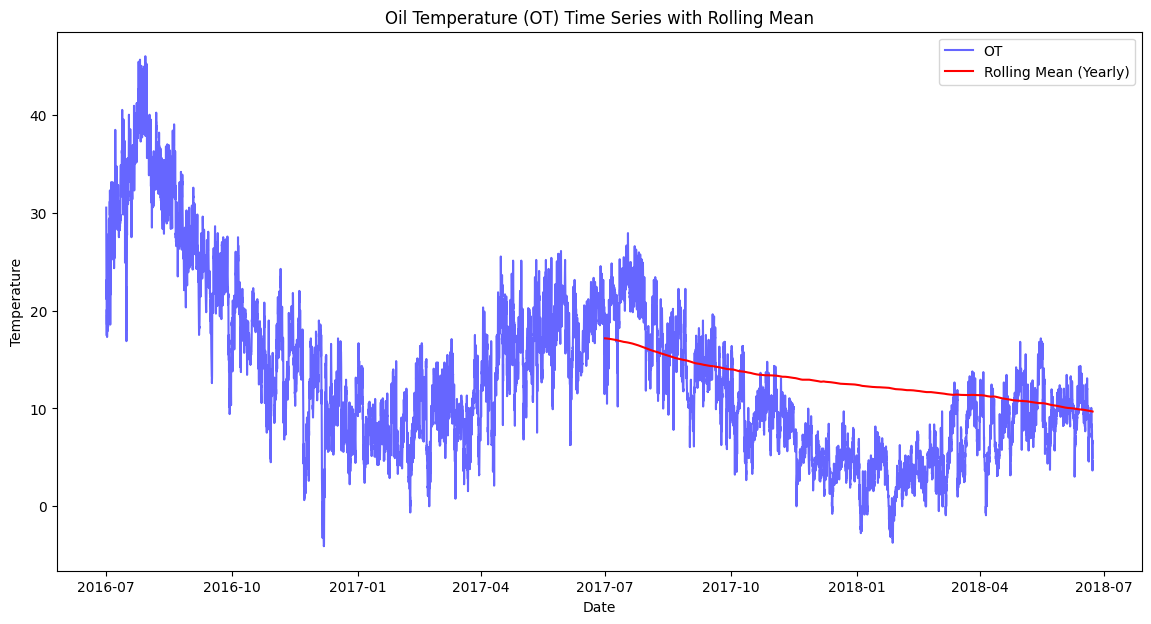

In [4]:
# Plotting the "OT" time series again with a rolling mean to identify trends
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['OT'], label='OT', color='blue', alpha=0.6)
plt.plot(df['OT'].rolling(window=365*24).mean(), label='Rolling Mean (Yearly)', color='red')
plt.title('Oil Temperature (OT) Time Series with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [5]:
# Normalize the 'OT' column
scaler = MinMaxScaler()
df['OT_normalized'] = scaler.fit_transform(df[['OT']])


In [6]:
df.tail(100)

,OT,OT_normalized
date,,
2018-06-18 12:00:00,10.833,0.297742
2018-06-18 13:00:00,11.185,0.304770
2018-06-18 14:00:00,11.959,0.320223
2018-06-18 15:00:00,13.085,0.342704
2018-06-18 16:00:00,11.959,0.320223
...,...,...
2018-06-22 11:00:00,6.753,0.216284
2018-06-22 12:00:00,3.658,0.154491
2018-06-22 13:00:00,3.658,0.154491


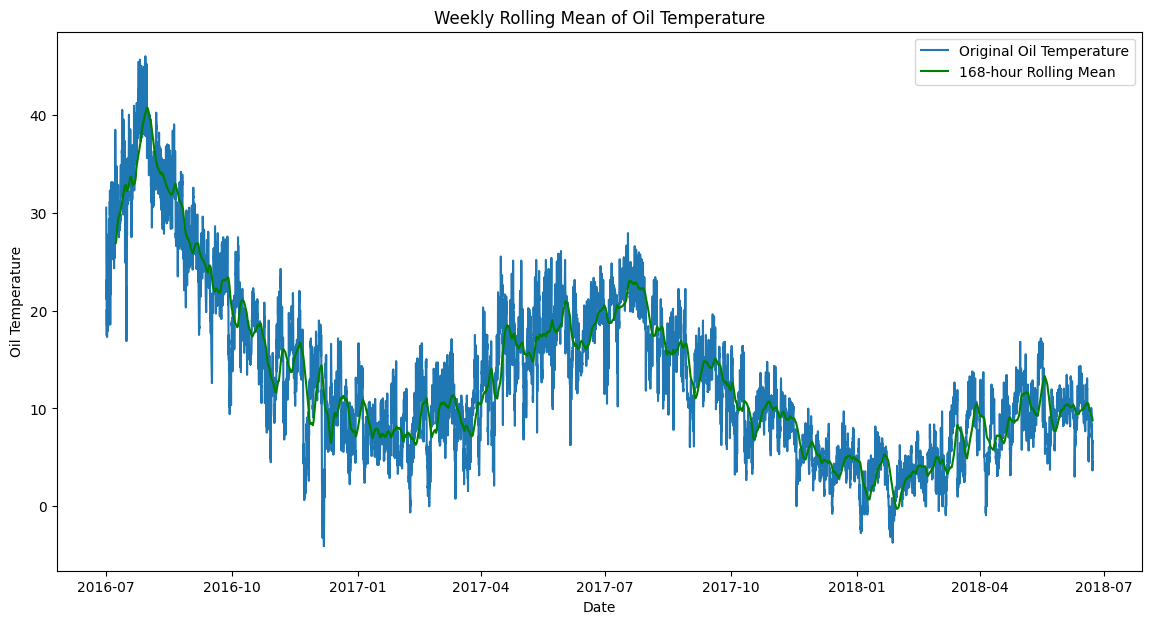

In [7]:
roll_mean_weekly = df['OT'].rolling(window=168).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['OT'], label='Original Oil Temperature')
plt.plot(roll_mean_weekly, color='green', label='168-hour Rolling Mean')
plt.title('Weekly Rolling Mean of Oil Temperature')
plt.xlabel('Date')
plt.ylabel('Oil Temperature')
plt.legend()
plt.show()


In [8]:
 #Function to create sequences from the time series data
def create_sequences(input_data, window_size):
    X = []
    Y = []
    for i in range(len(input_data) - window_size):
        X.append(input_data[i:(i + window_size), 0])
        Y.append(input_data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [9]:
# Prepare sequences using the normalized 'OT' values
window_size = 5
X, Y = create_sequences(df[['OT_normalized']].values, window_size)

In [10]:

# Split the data into training and test sets (excluding the last 100 values for testing)
X_train = X[:-100]
Y_train = Y[:-100]
X_test = X[-100:]
Y_test = Y[-100:]

In [11]:
# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

In [12]:
 #Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dense(1)
])

/Users/thiamaziz/Desktop/forecasting/forecasting/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
 #Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])


In [14]:

# (Optional) Print model summary to verify architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
model.fit(X_train, Y_train, validation_split=0.1, epochs=20, batch_size=64)

Epoch 1/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0271 - root_mean_squared_error: 0.1485 - val_loss: 4.6821e-04 - val_root_mean_squared_error: 0.0216
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.9659e-04 - root_mean_squared_error: 0.0316 - val_loss: 4.5256e-04 - val_root_mean_squared_error: 0.0213
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0877e-04 - root_mean_squared_error: 0.0301 - val_loss: 4.5030e-04 - val_root_mean_squared_error: 0.0212
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.2355e-04 - root_mean_squared_error: 0.0287 - val_loss: 4.0720e-04 - val_root_mean_squared_error: 0.0202
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.7775e-04 - root_mean_squared_error: 0.0279 - val_loss: 3.7575e-04 - val_root_mean_squared_error: 0.0194
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2796e-04 - root_mean_squared_error: 0.0270 - val_loss: 3.6473e-04 - val_root_mean_squared_error: 0.0191
Epoch 7/

In [16]:
# After training,evaluate the model
model.evaluate(X_test, Y_test) 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 3.6515e-04 - root_mean_squared_error: 0.0175


[0.00043617436313070357, 0.017011279240250587]

In [17]:
model.predict(X_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.27579603],
       [0.28796843],
       [0.29708442],
       [0.31093755],
       [0.3321021 ],
       [0.31855062],
       [0.3136287 ],
       [0.3135675 ],
       [0.31085625],
       [0.29057232],
       [0.2783157 ],
       [0.2757075 ],
       [0.27855906],
       [0.27176777],
       [0.26052746],
       [0.2577863 ],
       [0.25598335],
       [0.2546157 ],
       [0.2565609 ],
       [0.2651302 ],
       [0.26537982],
       [0.25789618],
       [0.25991252],
       [0.268051  ],
       [0.27150938],
       [0.276103  ],
       [0.27155605],
       [0.20350802],
       [0.1833422 ],
       [0.16882116],
       [0.17625003],
       [0.20145808],
       [0.21084867],
       [0.21670736],
       [0.17886159],
       [0.1737347 ],
       [0.18773672],
       [0.20328459],
       [0.21874475],
       [0.21692789],
       [0.21680339],
       [0.21683964],
       [0.21696454],
       [0.22018158],
       [0.223425  ],
       [0.21873605],
       [0.22222733],
       [0.233

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0  # Set verbose to 1 or 2 to see the training progress
)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and the actual Y_test values to their original scale
predictions_inverse = scaler.inverse_transform(predictions)
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Prepare data for plotting
preds = predictions_inverse.flatten()
actuals = Y_test_inverse.flatten()

(preds[:10], actuals[:10])  # Display the first 10 predictions and actual values for comparison


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step


(array([10.084517 , 10.806655 , 11.197298 , 11.939658 , 13.052701 ,
        12.0255165, 11.988415 , 12.016258 , 11.828464 , 10.6672125],
       dtype=float32),
 array([10.83300018, 11.18500042, 11.95899963, 13.08500004, 11.95899963,
        12.02900028, 12.02900028, 11.81799984, 10.62199974, 10.19999981]))

In [19]:
test_dates = df.index[-100:]  # Assuming 'df' has 'date' set as its index

# Create a DataFrame for comparing predictions with actual values
comparison_df = pd.DataFrame({
    'date': test_dates,
    'Actual': actuals,  # 'actuals' needs to be defined previously
    'Predicted': preds  # 'preds' needs to be defined previously
})

# Display the DataFrame
comparison_df.to_csv('comparaison.csv',index=False)
comparison_df


,date,Actual,Predicted
0,2018-06-18 12:00:00,10.833,10.084517
1,2018-06-18 13:00:00,11.185,10.806655
2,2018-06-18 14:00:00,11.959,11.197298
3,2018-06-18 15:00:00,13.085,11.939658
4,2018-06-18 16:00:00,11.959,13.052701
...,...,...,...
95,2018-06-22 11:00:00,6.753,6.515730
96,2018-06-22 12:00:00,3.658,6.803408
97,2018-06-22 13:00:00,3.658,4.011247
98,2018-06-22 14:00:00,4.150,3.663345


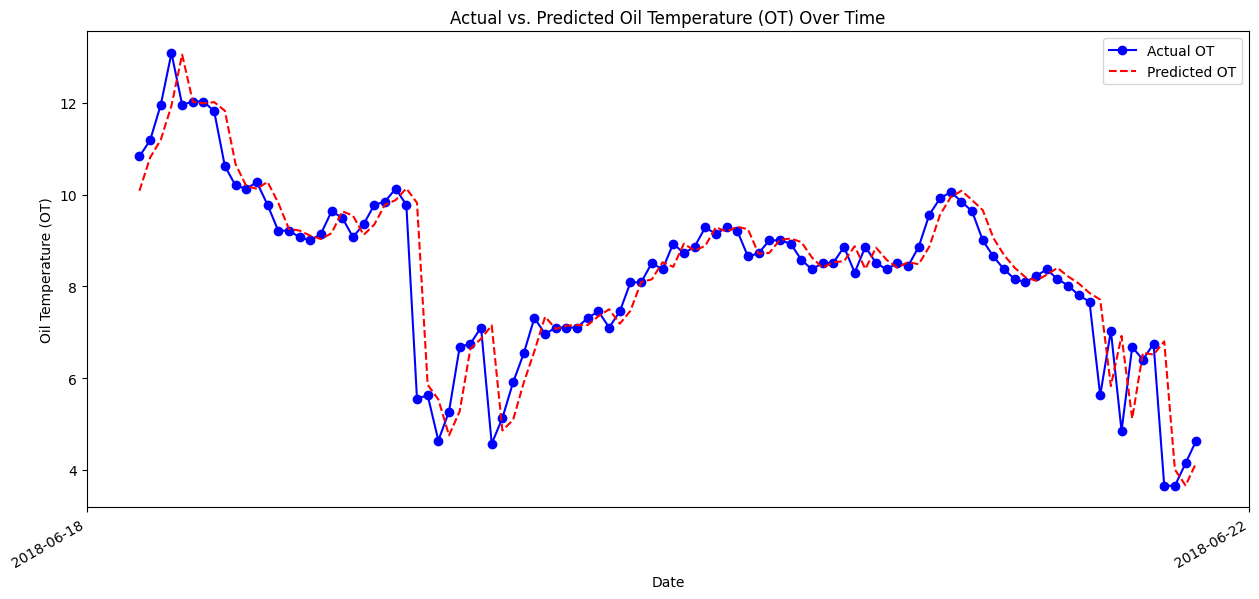

In [20]:

# Sample DataFrame 'comparison_df' columns: 'Date', 'Actual', 'Predicted'
# Ensure 'Date' is in datetime format; if not, convert it
comparison_df['date'] = pd.to_datetime(comparison_df['date'])

# Plotting
plt.figure(figsize=(15, 7))  # Set the figure size for better readability
plt.plot(comparison_df['date'], comparison_df['Actual'], label='Actual OT', color='blue', marker='o')
plt.plot(comparison_df['date'], comparison_df['Predicted'], label='Predicted OT', color='red', linestyle='--')

# Formatting the plot
plt.title('Actual vs. Predicted Oil Temperature (OT) Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Temperature (OT)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Adjust interval for better readability
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()


In [21]:
mae = mean_absolute_error(actuals, preds)

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.47458090066909775


In [26]:

# Function to make future predictions, returning both the scaled and original values
def make_future_predictions(model, scaler, last_window, future_steps=100):
    future_preds_scaled = []
    current_step = last_window
    
    for _ in range(future_steps):
        # Predict the next step
        next_step_pred = model.predict(current_step.reshape((1, window_size, 1)))
        future_preds_scaled.append(next_step_pred.flatten()[0])
        
        # Update the current step to include the prediction
        current_step = np.roll(current_step, -1, axis=0)
        current_step[-1] = next_step_pred
        
    # Inverse transform to get predictions back to their original scale
    future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()
    
    return future_preds

# Assuming df['OT_normalized'] and scaler are already defined
window_size = 5  # This should match the window_size used during training
last_window = df['OT_normalized'].values[-window_size:]

# Generate the next 100 future predictions
future_predictions = make_future_predictions(model, scaler, last_window, future_steps=100)

# Create a DataFrame for the predictions with an ID column starting at 0
future_df = pd.DataFrame({
    'Id': range(0, 100),  # Generate IDs from 0 to 99
    'OT': future_predictions
})

# Display the first few rows to verify
print(future_df.tail())

# Save the future predictions to a CSV file
future_df.to_csv('future_ot_predictions.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/var/folders/nd/zqzyx7f11f39z7k57jd4z3sh0000gn/T/ipykernel_56726/503338534.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_step[-1] = next_step_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1